In [1]:
# ORIGINAL RGB FILE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tqdm

from IPython.display import display

from matplotlib import rc
rc("font", family="serif", size=11)

In [2]:
output = pd.read_csv('../data/output_1000stars.csv', usecols=range(1,4))
#IDs = [(output.loc[output['ID'] == random.choice(output['ID'])]).iloc[0]['Numax'] for i in range(5)]

# Select a random number of stars from the file, recording their IDs
IDs = [random.choice(output['ID']) for i in range(5)]
# Create a list of the numax values corresponding to each ID
Numax = [(output.loc[(output['ID'] == IDs[i])]).iloc[0]['Numax'] for i in range(len(IDs))]

print(IDs)
print(Numax)

[11136854, 12217154, 7270142, 12120230, 9641484]
[93.37199785236638, 46.40697232766959, 51.909372934635016, 49.03668333059515, 35.792618243061135]


In [3]:
modesID = [pd.read_csv('../data/rgbmodes/modes_'+str(IDs[i])+'.csv', usecols=['f0', 'f0_err', 'A0'])
           for i in np.arange(0,len(IDs),1)]
lenmodes = [len(modesID[i]) for i in range(len(IDs))]
maxmodes = max(lenmodes)

dnu_avgID = []
for i in np.arange(0,len(IDs),1):
    modesID[i] = modesID[i].sort_values(by=['f0'])
    modesID[i] = modesID[i].set_index(np.arange(0,len(modesID[i]),1))
    modesID[i]['dnu'] = (modesID[i]['f0'].diff(2).shift(-1))/2
    dnu_avg = (np.mean(modesID[i]['dnu']))
    dnu_avgID.append(dnu_avg)
    
    n_min = int(modesID[i]['f0'].min() / dnu_avg)
    n = np.arange(n_min, n_min+len(modesID[i]), 1)
    modesID[i].insert(loc=0, column='n', value=n)
    
    # Loop to ensure all arrays are the same length
    if lenmodes[i] < maxmodes:
        l = lenmodes[i]
        while l < maxmodes:
            newrow = {'n': int(np.max(modesID[i]['n'])+1),
                      'f0': np.max(modesID[i]['f0'])+dnu_avgID[i],
                      'f0_err': 100000}
            modesID[i] = modesID[i].append(newrow, ignore_index=True)
            #modesID[i].loc[l] = [l, int(np.max(modesID[i]['n']+l)), (np.max(modesID[i]['dnu'])+dnu_avgID[i]), np.nan , 10000]
            #app = pd.DataFrame([(np.max(modesID[i]['dnu'])+dnu_avgID[i]), 10000], columns=['n', 'f0', 'f0_err'])
            #modesID[i].append(app, ignore_index=True)
            l += 1
    
    display(modesID[i])

print(dnu_avgID)

,n,f0,A0,f0_err,dnu
0,9,66.746416,-0.848495,0.090001,NaN
1,10,73.906266,-0.319294,0.042919,7.087849
2,11,80.922113,0.232132,0.023522,7.155591
3,12,88.217448,0.367932,0.021051,7.370166
4,13,95.662444,0.068669,0.028141,7.330537
5,14,102.878522,-0.040056,0.069845,7.317677
6,15,110.297799,-0.227093,0.077412,7.306409
7,16,117.491339,-1.238457,0.107079,NaN


,n,f0,A0,f0_err,dnu
0,7.0,32.694058,-0.832398,0.030040,NaN
1,8.0,37.191669,-0.103241,0.023610,4.449384
2,9.0,41.592825,0.359628,0.020489,4.548115
3,10.0,46.287899,0.487758,0.015323,4.661193
4,11.0,50.915212,0.594391,0.021144,4.662548
5,12.0,55.612996,0.037515,0.027460,4.793844
6,13.0,60.502901,-0.731449,0.056265,NaN
7,14.0,65.125918,NaN,100000.000000,NaN


,n,f0,A0,f0_err,dnu
0,6,33.702264,-1.157033,0.051835,NaN
1,7,39.029883,-0.345313,0.024905,5.216136
2,8,44.134537,0.121272,0.013088,5.259793
3,9,49.549468,0.511425,0.007968,5.415405
4,10,54.965348,0.646176,0.011096,5.456114
5,11,60.461696,0.195818,0.018682,5.461497
6,12,65.888342,0.102848,0.047662,5.528077
7,13,71.517850,-0.866371,0.093687,NaN


,n,f0,A0,f0_err,dnu
0,7.0,37.826682,-0.317364,0.015663,NaN
1,8.0,42.797244,0.249567,0.016247,5.156973
2,9.0,48.140628,0.614829,0.010774,5.299240
3,10.0,53.395724,0.588961,0.013621,5.293209
4,11.0,58.727045,0.386716,0.022994,5.373463
5,12.0,64.142650,-0.395619,0.042314,5.591615
6,13.0,69.910275,-2.792225,0.105442,NaN
7,14.0,75.253174,NaN,100000.000000,NaN


,n,f0,A0,f0_err,dnu
0,6.0,24.534314,-0.992802,0.038731,NaN
1,7.0,28.542686,-0.206563,0.023949,3.909228
2,8.0,32.352770,0.293874,0.010907,3.987417
3,9.0,36.517520,0.484629,0.012442,4.167669
4,10.0,40.688107,0.090881,0.028255,4.121275
5,11.0,44.760069,-0.024363,0.020519,NaN
6,12.0,48.806466,NaN,100000.000000,NaN
7,13.0,52.852863,NaN,100000.000000,NaN


[7.26137136031367, 4.62301694622893, 5.389503771679604, 5.3428998847724865, 4.046396989342222]


NameError: name 'stars' is not defined

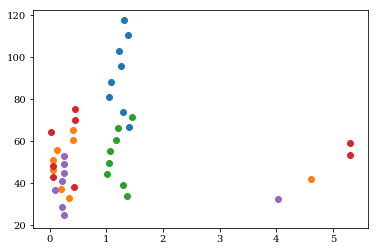

In [4]:
for i in np.arange(0,len(IDs),1):
    plt.scatter(modesID[i]['f0'] % dnu_avgID[i], modesID[i]['f0'], label=r'ID = '+str(IDs[i]))

def model(n, dnu, nmax, epsilon, k, a, omega, phi, tau):
    freqs = (n + epsilon) * dnu
    freqs += (nmax-n)**2 * k
    freqs += a*np.sin(omega*n + phi)*np.exp(-n/tau)
    return freqs

nmax = 11
numax = stars.iloc[0]['Numax']
epsilon = 0.77
epsilon = numax/dnu_avg - nmax
k = 0.03
a = 0.2
omega = 3
phi = 2
tau = 10

f = model(n, dnu_avg, nmax, epsilon, k, a, omega, phi, tau)

plt.plot(f % dnu_avg, f, label='model')
plt.ylabel('Frequency')
plt.xlabel(r'Mod. Freq. Spacing ('+ str(u"%.3f" % dnu_avg) +') $\mu$Hz')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [17]:
code = '''
functions {
    real model(real n, real dnu, real nmax, real epsilon, real k, real a, real omega, real phi, real tau){
        return (dnu*(n+epsilon) + k*(nmax - n)^2 + a*sin(omega*n + phi)*exp(-n/tau));
    }
}
data {
    int N;   // Number of induvidual stars
    int M;   // Number of induvidual modes
    real n[N,M];
    real freq[N,M];
    real freq_err[N,M];
    real dnu_guess[N]; // Calculated average dnu for each star
    real numax[N];     // List of numax for each star
}
parameters {
    real<lower = 0> dnu[N];
    real<lower = 0> nmax[N];
    real epsilon[N];
    real k[N];
    real<lower = 0> a[N];
    real<lower = 0> omega[N];
    real<lower = -2.0*pi(), upper = 2.0*pi()> phi[N];
    real<lower = 0> tau[N];
}
model {
    real mod;
    for (i in 1:N){
        for (j in 1:M){
            mod = model(n[i,j], dnu[i], nmax[i], epsilon[i], k[i], a[i], omega[i], phi[i], tau[i]);
            mod ~ normal(freq[i,j], freq_err[i,j]);
        }
    }
    for (i in 1:N){
        dnu[i] ~ normal(dnu_guess[i], dnu_guess[i]*0.001);
        epsilon[i] ~ normal(numax[i]/dnu[i] - nmax[i], 0.4); // What is this???
    }
    nmax ~ normal(9,1.7);
    k ~ lognormal(log(0.04), 0.003);
    a ~ lognormal(log(0.2), 0.01);
    omega ~ normal(3, 0.3);
    tau ~ normal(8,1.6);
}
'''
import pystan
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_28838f5b0b0f943d15fba5955d4773e2 NOW.


In [18]:
fits = []

stan_data = {'N': len(modesID['n'].values),
            'M': !!!DEFINE M!!!
         'n': modesID['n'].values, 
         'freq': (modesID['f0'].values),
         'freq_err': modesID['f0_err'].values,
         'dnu_guess': dnu_avgID,
         'numax': star.iloc[0]['Numax']
        }
start = {'dnu': dnu_avg,
         'nmax': nmax,
         'epsilon': epsilon,
         'k': k,
         'a': a,
         'omega': omega,
         'phi': phi,
         'tau': tau
    }
nchains = 4

fit = sm.sampling(data=stan_data, iter=5000, chains=nchains, init=[start for n in range(nchains)],)
    

SyntaxError: invalid syntax (<ipython-input-18-4d303a63bdc4>, line 4)

In [85]:
fitsdf.to_csv('manystars.csv')
fitsdf.head()

,dnu,nmax,epsilon,k,a,omega,phi,tau
0,3.774666,8.909744,-0.074084,0.040001,0.200128,3.696033,-0.287783,9.418238
1,3.977722,8.245239,-0.021279,0.039998,0.200136,2.318750,4.942493,9.519606
2,5.346790,10.247160,0.128692,0.039996,0.199988,2.960478,2.535166,7.896521
3,4.996504,7.429712,0.010132,0.040928,0.221116,2.159576,6.273541,34.229910
4,4.384523,8.646312,-0.041921,0.039990,0.200043,2.478256,2.859963,9.080585


In [78]:
print(fit)

Inference for Stan model: anon_model_7d503acfff46dba04e2557476cb5050f.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       4.21  5.9e-5 4.3e-3    4.2    4.2   4.21   4.21   4.21   5139    1.0
nmax      8.27  1.5e-3   0.11   8.05   8.19   8.27   8.34   8.48   5683    1.0
epsilon   0.03  1.2e-4 8.7e-3   0.01   0.02   0.03   0.04   0.05   5124    1.0
k         0.04  1.2e-6 1.2e-4   0.04   0.04   0.04   0.04   0.04  10426    1.0
a          0.2  2.5e-5 2.0e-3    0.2    0.2    0.2    0.2    0.2   6520    1.0
omega     2.58    0.02   0.29    2.3   2.43   2.51    2.6   3.64    301   1.02
phi       3.13    0.14   2.39  -5.67   2.89   3.71   4.35   5.45    303   1.02
tau        9.5    0.02   1.15   7.36   8.71   9.46  10.25  11.86   5661    1.0
lp__     -2.27    0.07   2.26   -7.5  -3.61  -1.89  -0.56   1.06   1087    1.0

Samples were drawn 

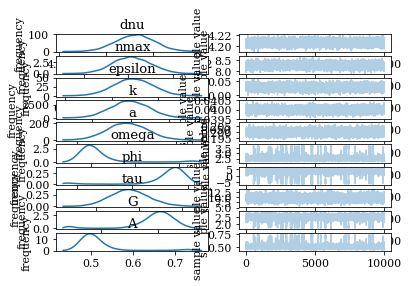

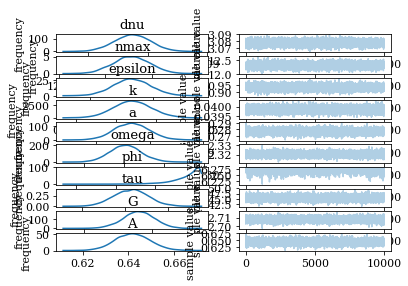

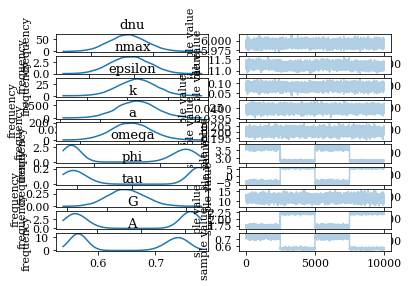

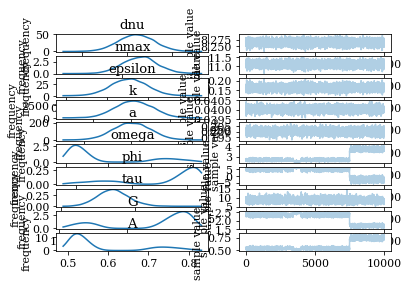

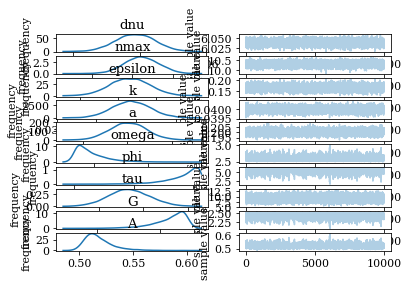

In [70]:
for i in fits:
    i.plot()
plt.show()

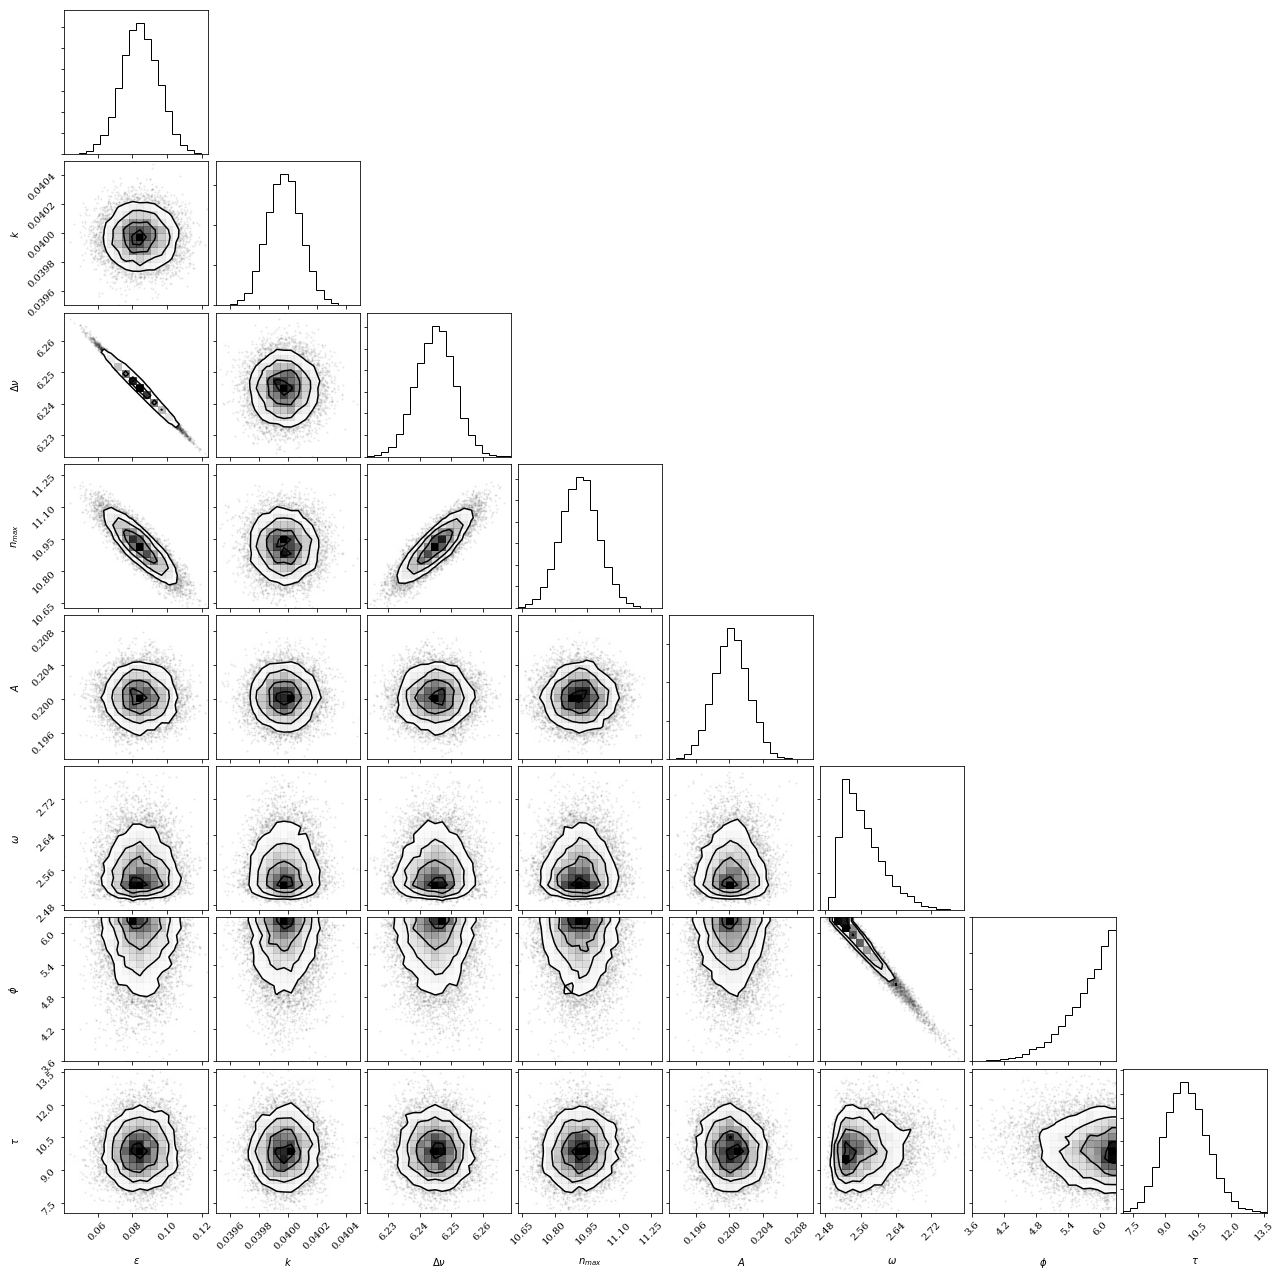

In [19]:
import corner
data = np.vstack([fit['epsilon'], fit['k'], fit['dnu'], fit['nmax'],
                  fit['a'], fit['omega'], fit['phi'], fit['tau']]).T
corner.corner(data, labels=[r'$\epsilon$', r'$k$',r'$\Delta\nu$',r'$n_{max}$',
                            r'$A$', r'$\omega$', r'$\phi$', r'$\tau$'])
              #, truths=[1.436, 0.07, 0.3, 2, 0])
plt.show()

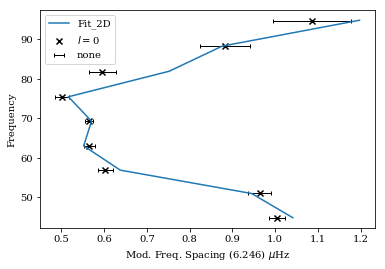

In [23]:
#n = np.arange(12,30,1)

plt.figure(4)
plt.scatter(modes['f0'] % dnu_avg, modes['f0'], c='k', marker='x', label=r'$l=$'+str(0))
plt.errorbar(modes['f0'] % dnu_avg, modes['f0'], xerr=modes['f0_err'], zorder=0, fmt="none", label="none",
             c='k', capsize=2, markersize=4, elinewidth=1)

#g = model(n, fit['dnu'].mean(), fit['nmax'].mean(), fit['epsilon'].mean(), fit['k'].mean(),
#          fit['A'].mean(), np.median(fit['omega']), fit['phi'].mean(), fit['tau'].mean())
g2 = model(n, fit['dnu'].mean(), fit['nmax'].mean(), fit['epsilon'].mean(), fit['k'].mean(),
          fit['a'].mean(), np.median(fit['omega']), fit['phi'].mean(), fit['tau'].mean())
#plt.plot(f % dnu_avg, f, ':', label='Guess')
#plt.plot(g % fit['dnu'].mean(), g, label='Fit')
plt.plot(g2 % fit['dnu'].mean(), g2, label='Fit_2D')
#plt.plot(g % dnu, g, label='Fit')

plt.ylabel('Frequency')
plt.xlabel(f'Mod. Freq. Spacing ('+ str(u"%.3f" % dnu_avg) +') $\mu$Hz')
#plt.xlim(58,68)
plt.legend()
plt.show()